In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import neural_network
import matplotlib.pyplot as plt
from sklearn import neural_network
from sklearn import linear_model
import itertools

from tensorflow.python.layers.normalization import normalization

In [101]:
import cv2
import os
import numpy as np
from PIL import Image

def loadImageData(folder, target_size=(300, 300)):
    inputs = []
    outputs = []

    for filename in os.listdir(folder):
        source_file = os.path.join(folder, filename)
        if os.path.isfile(source_file) and any(
                filename.lower().endswith(image_extension) for image_extension in ['.jpg', '.png']):
            if folder == 'data':
                outputs.append(0)
            elif folder == 'data_sepia':
                outputs.append(1)
            image = cv2.imread(source_file)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                inputs.append(resized_image)
            else:
                print('Could not read image:', source_file)

    return inputs, outputs

inData, outData = loadImageData('data')
inDataSepia, outDataSepia = loadImageData('data_sepia')

inputs = inData + inDataSepia
outputs = outData + outDataSepia
outputNames = ['normal', 'sepia']



Pasul 2 - impartire pe train si test; normalizare; analiza distributiei datelor pe clase - pt a verifica daca e echilibrat setul de train


In [102]:
# step2: split data into train and test

def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]

    return trainInputs, trainOutputs, testInputs, testOutputs

In [103]:
def normalisation(trainData, testData):
    scaler = StandardScaler()

    trainData = np.array(trainData)
    testData = np.array(testData)

    if trainData.ndim != 2 or testData.ndim != 2:
        raise ValueError("trainData and testData must be 2D arrays")

    scaler.fit(trainData)

    normalisedTrainData = scaler.transform(trainData)
    normalisedTestData = scaler.transform(testData)

    return normalisedTrainData, normalisedTestData

In [104]:
def data2FeaturesMoreClasses(inputs, outputs):
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noData) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = outputNames[crtLabel])
    plt.xlabel('feat1')
    plt.ylabel('feat2')
    plt.legend()
    plt.show()

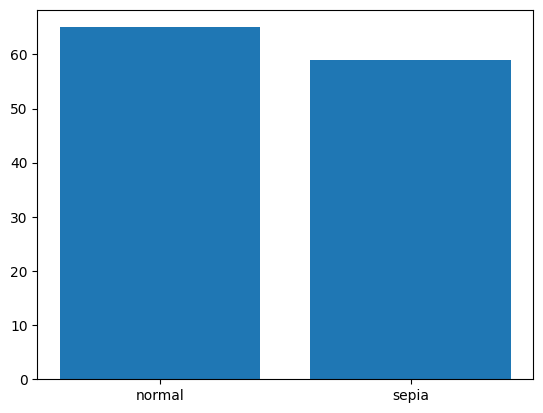

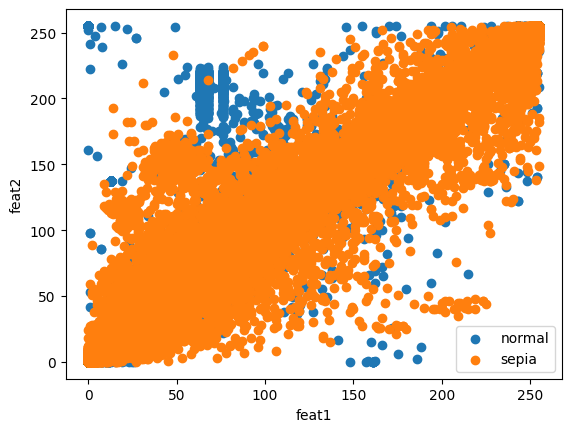

In [105]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

# plot the training data distribution on classes
bins = range(len(outputNames) + 1)
plt.hist(trainOutputs, bins, rwidth = 0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), outputNames)
plt.show()

# plot the data
#data2FeaturesMoreClasses(trainInputs, trainOutputs)


# to be 2d array
def flatten_images(data):
    return np.array(data).reshape(len(data), -1)

trainInputsFlatten = flatten_images(trainInputs)
testInputsFlatten = flatten_images(testInputs)

# normalise the data
trainInputs, testInputs = normalisation(trainInputsFlatten, testInputsFlatten)

Pasul 3 - invatare model (cu tool neural_network.MLPClassifier() -- link)


In [106]:
import numpy as np

class MyANN:
    def __init__(self, hidden_layer_sizes=(5,), learning_rate=0.001, max_iter=200, random_state=None,
                 verbose=10):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.weights = []
        self.biases = []

    def _initialize_parameters(self, input_dim, output_dim):
        layer_dims = [input_dim] + list(self.hidden_layer_sizes) + [output_dim]

        for i in range(1, len(layer_dims)):
            weight = np.random.randn(layer_dims[i - 1], layer_dims[i]) * 0.01
            bias = np.zeros((1, layer_dims[i]))
            self.weights.append(weight)
            self.biases.append(bias)

    def _relu(self, Z):
        return np.maximum(0, Z)

    def _relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def fit(self, X, y):
        X = np.array(X)

        num_samples, num_features = X.shape
        output_dim = 1

        self._initialize_parameters(num_features, output_dim)

        y = np.array(y).reshape(-1, 1)

        for i in range(self.max_iter):
            # Forward pass
            a = [X]
            for weight, bias in zip(self.weights, self.biases):
                z = np.dot(a[-1], weight) + bias
                a.append(self._relu(z))

            # Backward pass
            dz = a[-1] - y
            for j in range(len(self.weights) - 1, -1, -1):
                dw = (1 / X.shape[0]) * np.dot(a[j].T, dz)
                db = (1 / X.shape[0]) * np.sum(dz, axis=0, keepdims=True)
                dz = np.dot(dz, self.weights[j].T) * self._relu_derivative(a[j])
                self.weights[j] -= self.learning_rate * dw
                self.biases[j] -= self.learning_rate * db

            if self.verbose and i % 10 == 0:
                loss = np.mean(np.square(y - a[-1]))
                print('Iteration %d, loss = %.4f' % (i, loss))


    def predict(self, X):
        A = X
        for W, b in zip(self.weights, self.biases):
            Z = np.dot(A, W) + b
            A = self._relu(Z)

        return (A >= 0.5).astype(int)


In [120]:

classifier = neural_network.MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=100, solver='sgd', verbose=True, random_state=1, learning_rate_init=0.0001, alpha=0.0001)

#classifier = MyANN()

trainInputs = np.array(trainInputs)
trainOutputs = np.array(trainOutputs)
# identify (by training) the classification model
classifier.fit(trainInputs, trainOutputs)

Iteration 1, loss = 1.28008829
Iteration 2, loss = 0.85709282
Iteration 3, loss = 0.55586987
Iteration 4, loss = 0.35956611
Iteration 5, loss = 0.31045331
Iteration 6, loss = 0.27567171
Iteration 7, loss = 0.24345390
Iteration 8, loss = 0.21892930
Iteration 9, loss = 0.19931813
Iteration 10, loss = 0.18363185
Iteration 11, loss = 0.17056739
Iteration 12, loss = 0.15953481
Iteration 13, loss = 0.15077004
Iteration 14, loss = 0.14325301
Iteration 15, loss = 0.13667933
Iteration 16, loss = 0.13112850
Iteration 17, loss = 0.12632074
Iteration 18, loss = 0.12196050
Iteration 19, loss = 0.11793687
Iteration 20, loss = 0.11427526
Iteration 21, loss = 0.11106056
Iteration 22, loss = 0.10812191
Iteration 23, loss = 0.10545291
Iteration 24, loss = 0.10305513
Iteration 25, loss = 0.10080900
Iteration 26, loss = 0.09871273
Iteration 27, loss = 0.09692667
Iteration 28, loss = 0.09533651
Iteration 29, loss = 0.09384206
Iteration 30, loss = 0.09257187
Iteration 31, loss = 0.09141349
Iteration 32, los

C:\Users\munte\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5,), learning_rate_init=0.0001, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

In [121]:
predictedLabels = classifier.predict(testInputs)


In [122]:
def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools

    classes = classNames
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment = 'center',
                color = 'white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

def evalMultiClass(realLabels, computedLabels, labelNames):
    from sklearn.metrics import confusion_matrix

    confMatrix = confusion_matrix(realLabels, computedLabels)
    acc = sum([confMatrix[i][i] for i in range(len(labelNames))]) / len(realLabels)
    precision = {}
    recall = {}
    for i in range(len(labelNames)):
        precision_denominator = sum([confMatrix[j][i] for j in range(len(labelNames))])
        recall_denominator = sum([confMatrix[i][j] for j in range(len(labelNames))])

        precision[labelNames[i]] = confMatrix[i][i] / precision_denominator if precision_denominator != 0 else 0
        recall[labelNames[i]] = confMatrix[i][i] / recall_denominator if recall_denominator != 0 else 0

    return acc, precision, recall, confMatrix

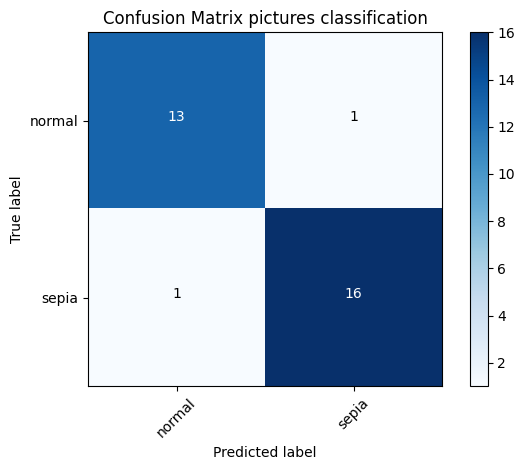

acc:  0.9354838709677419
precision:  {'normal': 0.9285714285714286, 'sepia': 0.9411764705882353}
recall:  {'normal': 0.9285714285714286, 'sepia': 0.9411764705882353}


In [123]:
acc, prec, recall, cm = evalMultiClass(np.array(testOutputs), predictedLabels, outputNames)
plotConfusionMatrix(cm, outputNames, "pictures classification")

print('acc: ', acc)
print('precision: ', prec)
print('recall: ', recall)

In [124]:
def predict_image(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))
    image = image.reshape((1, 300*300*3))
    prediction = model.predict(image)
    return "Normal" if prediction[0] == 0 else "Sepia"



print(predict_image(classifier, 'test/bird-8788491_1280.jpg')) #normal
print(predict_image(classifier, 'test/parissepia.jpg')) #sepia



Normal
Sepia
